## Kaggle - HR Analysis

**A company is trying to figure out why their best and experienced employees are leaving prematurely.**

In [1]:
import os
import subprocess
def module(*args):        
    if isinstance(args[0], list):        
        args = args[0]        
    else:        
        args = list(args)        
    (output, error) = subprocess.Popen(['/usr/bin/modulecmd', 'python'] + args, stdout=subprocess.PIPE).communicate()
    exec(output)    
module('load', 'apps/java/jdk1.8.0_102/binary')    
os.environ['PYSPARK_PYTHON'] = os.environ['HOME'] + '/.conda/envs/jupyter-spark/bin/python'

In [2]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[2]") \
    .appName("COM6012 PCA") \
    .getOrCreate()

sc = spark.sparkContext

In [3]:
df = spark.read.csv("../Data/HR_comma_sep.csv", header="true",inferSchema="true")

df.show(5)

+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+-----+------+
|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|sales|salary|
+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+-----+------+
|              0.38|           0.53|             2|                 157|                 3|            0|   1|                    0|sales|   low|
|               0.8|           0.86|             5|                 262|                 6|            0|   1|                    0|sales|medium|
|              0.11|           0.88|             7|                 272|                 4|            0|   1|                    0|sales|medium|
|              0.72|           0.87|             5|                 223|                 5|            0|   1|              

In [4]:
df.printSchema()

root
 |-- satisfaction_level: double (nullable = true)
 |-- last_evaluation: double (nullable = true)
 |-- number_project: integer (nullable = true)
 |-- average_montly_hours: integer (nullable = true)
 |-- time_spend_company: integer (nullable = true)
 |-- Work_accident: integer (nullable = true)
 |-- left: integer (nullable = true)
 |-- promotion_last_5years: integer (nullable = true)
 |-- sales: string (nullable = true)
 |-- salary: string (nullable = true)



In [5]:
import seaborn as sns # install package under jupyter-spark in HPC.

/home/acz19yz/.conda/envs/jupyter-spark/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Pyspark Dataframe 计算相关系数：df.stat.corr()

**相关系数为一种特殊的协方差，其消除了两个变量变化幅度的影响，而只是单纯反应两个变量每单位变化时的相似程度。如下图所示：**

<img src="image_github/corr.png" width="500" height="500">

In [6]:
import pandas as pd

corr_df = pd.DataFrame(columns=df.columns[:8], dtype=float)

for i, row in enumerate(df.columns[:8]):
    for col in df.columns[:8]:
        corr_df.loc[i, col] = df.stat.corr(row, col) # value type object.
    # corr_df.loc[i].astype(float)
    
corr_df.index = df.columns[:8]

In [7]:
corr_df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433
Work_accident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245
left,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788
promotion_last_5years,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000


Text(0.5, 1, 'Correlation between different fearures')

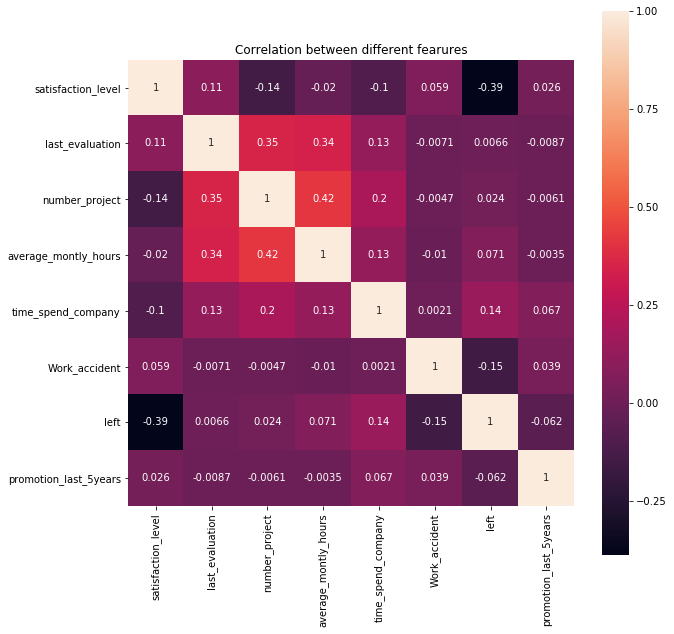

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
sns.heatmap(corr_df, square=True, annot=True)

plt.title('Correlation between different fearures')

### 展示岗位种类：

In [9]:
df.select(df.sales).distinct().count()

10

In [10]:
df.groupBy('sales').count().show()

+-----------+-----+
|      sales|count|
+-----------+-----+
| management|  630|
|product_mng|  902|
|  marketing|  858|
|      sales| 4140|
|         hr|  739|
| accounting|  767|
|    support| 2229|
|         IT| 1227|
|  technical| 2720|
|      RandD|  787|
+-----------+-----+



In [11]:
from pyspark.sql import functions as F

df_stat = df.groupBy('sales').agg(
    F.bround(F.mean('last_evaluation'), scale=4).alias('last_evaluation'), 
    F.bround(F.mean('satisfaction_level'), scale=4).alias('satisfaction_level'),
    F.bround(F.mean('number_project'), scale=4).alias('number_project'),
    F.bround(F.mean('average_montly_hours'), scale=4).alias('average_montly_hours'),
    F.bround(F.mean('time_spend_company'), scale=4).alias('time_spend_company'),
    F.bround(F.mean('Work_accident'), scale=4).alias('Work_accident'),
    F.bround(F.mean('left'), scale=4).alias('left'),
    F.bround(F.mean('promotion_last_5years'), scale=4).alias('promotion_last_5years')
)

pd_stat = df_stat.toPandas() # avoid new line. convert pyspark dataframe to pandas dataframe.

In [12]:
pd_stat

,sales,last_evaluation,satisfaction_level,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
0,management,0.7240,0.6213,3.8603,201.2492,4.3032,0.1635,0.1444,0.1095
1,product_mng,0.7148,0.6196,3.8071,199.9656,3.4756,0.1463,0.2195,0.0000
2,marketing,0.7159,0.6186,3.6876,199.3858,3.5699,0.1608,0.2366,0.0501
3,sales,0.7097,0.6144,3.7763,200.9114,3.5341,0.1418,0.2449,0.0242
4,hr,0.7088,0.5988,3.6549,198.6847,3.3559,0.1204,0.2909,0.0203
5,accounting,0.7177,0.5822,3.8253,201.1630,3.5228,0.1252,0.2660,0.0183
6,support,0.7231,0.6183,3.8039,200.7582,3.3930,0.1548,0.2490,0.0090
7,IT,0.7168,0.6181,3.8166,202.2160,3.4686,0.1337,0.2225,0.0024
8,technical,0.7211,0.6079,3.8779,202.4974,3.4114,0.1401,0.2562,0.0103
9,RandD,0.7121,0.6198,3.8539,200.8005,3.3672,0.1703,0.1537,0.0343


Text(0.5, 1.0, 'Mean Satisfaction Level of each department')

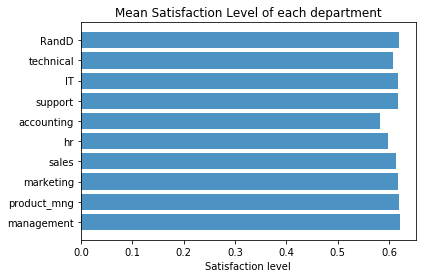

In [13]:
import numpy as np
satis_level = np.array(pd_stat['satisfaction_level'])
y_pos = np.arange(satis_level.shape[0])
plt.barh(y_pos, satis_level, align='center', alpha=0.8)
plt.yticks(y_pos,list(pd_stat['sales']))
plt.xlabel('Satisfaction level')
plt.title('Mean Satisfaction Level of each department')

### PCA：

**satisfaction_level, last_evaluation, number_project, average_montly_hours, time_spend_company, Work_accident, promotion_last_5years**

In [14]:
data = df.select('satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'promotion_last_5years',
    'left')

In [15]:
from pyspark.ml.linalg import Vectors
# convert the data to dense vector because ml api only accept this type.
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]), r[-1]]).toDF(['features', 'label'])

dfFtrvec = transData(data)
dfFtrvec.show(5, False)

+---------------------------------+-----+
|features                         |label|
+---------------------------------+-----+
|[0.38,0.53,2.0,157.0,3.0,0.0,0.0]|1    |
|[0.8,0.86,5.0,262.0,6.0,0.0,0.0] |1    |
|[0.11,0.88,7.0,272.0,4.0,0.0,0.0]|1    |
|[0.72,0.87,5.0,223.0,5.0,0.0,0.0]|1    |
|[0.37,0.52,2.0,159.0,3.0,0.0,0.0]|1    |
+---------------------------------+-----+
only showing top 5 rows



In [16]:
from pyspark.ml.feature import PCA
pca = PCA(k=5, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(dfFtrvec)

result = model.transform(dfFtrvec).select("pcaFeatures")
result.show(5, truncate=False)

+----------------------------------------------------------------------------------------------------+
|pcaFeatures                                                                                         |
+----------------------------------------------------------------------------------------------------+
|[157.02286349066927,2.421718772554353,-0.291751541737425,0.04514351747886546,0.4861679224330148]    |
|[262.05895025799697,5.445974974458119,0.8339131239998299,0.09359795893203786,1.0231940432246271]    |
|[272.0715604823676,4.018340905596155,3.2323834212257108,0.04477673178011242,0.3713744654761304]     |
|[223.0575997367518,4.736602350161396,1.457484509028622,0.08546384569244313,0.9504138819924157]      |
|[159.02273136503214,2.4089339520664725,-0.30963094990360895,0.04440076617685105,0.47380193645062746]|
+----------------------------------------------------------------------------------------------------+
only showing top 5 rows



In [17]:
model.explainedVariance

DenseVector([0.9986, 0.0009, 0.0005, 0.0, 0.0])

### Logistic Regression：

In [18]:
from pyspark.ml.feature import StandardScaler

standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
raw_data=standardscaler.fit(dfFtrvec).transform(dfFtrvec)
raw_data.show(5)

+--------------------+-----+--------------------+
|            features|label|     Scaled_features|
+--------------------+-----+--------------------+
|[0.38,0.53,2.0,15...|    1|[1.52837149554240...|
|[0.8,0.86,5.0,262...|    1|[3.21762420114190...|
|[0.11,0.88,7.0,27...|    1|[0.44242332765701...|
|[0.72,0.87,5.0,22...|    1|[2.89586178102771...|
|[0.37,0.52,2.0,15...|    1|[1.48815119302813...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [19]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="label", featuresCol="Scaled_features", maxIter=10)
model=lr.fit(raw_data)

In [20]:
model.coefficients

DenseVector([-1.046, 0.2245, -0.4373, 0.337, 0.3635, -0.5176, -0.311])

In [21]:
dict(zip(data.columns[:-1], model.coefficients))

{'Work_accident': -0.5176387225548083,
 'average_montly_hours': 0.3369899840010184,
 'last_evaluation': 0.2244698409381416,
 'number_project': -0.43730696860957263,
 'promotion_last_5years': -0.31095491947415643,
 'satisfaction_level': -1.0460228336700277,
 'time_spend_company': 0.3635246074193957}